In [ ]:
# 確率ロボティクス2017第9回-1

上田隆一

2017年11月15日@千葉工業大学

## 今日やること

* 強化学習（古典的なもの）
* 参考: [Sutton and Barto, 三上, 皆川訳: 強化学習, 森北出版, 2000.](https://www.amazon.co.jp/dp/4627826613)
  * [ウェブ版 ](http://webdocs.cs.ualberta.ca/~sutton/book/ebook/the-book.html)
  * [そろそろ第2版が出るらしい](http://www.freetechbooks.com/reinforcement-learning-an-introduction-second-edition-draft-t1282.html)
  
## 強化学習（reinforcement learning）

* 機械学習の一種
  * 起源: 動物の心理学研究から[宮崎2005]
    * 餌にありつけるような/危険を避けるような行動の学習
  * 最近ANN（人工ニューラルネットワーク）との組み合わせで脚光を浴びている
  
## 基本的な強化学習の問題

* 有限MDPでの行動決定の問題に一つ制限を与える
  * 状態遷移と報酬が、行動しないと分からない。
* 問題の定義
  * 時刻: $\mathcal{T} = \{t | t = 0,1,2,\dots,T \}$
  * 状態: $\mathcal{S} = \{s_i | i = 1,2,3,\dots,N\}$
    * うち、いくつかは終端状態の集合$\mathcal{S}_\text{f}$に含まれる
  * 行動: $\mathcal{A} = \{a_j | j = 1,2,3,\dots,M\}$
  * 状態遷移$\mathcal{P}_{ss'}^a$や報酬$\mathcal{R}_{ss'}^a$は時不変だが自明でない
    * ある確率分布に従って状態遷移する
    * ある法則に従って報酬が与えられる 

## 何を求めたいのか

* 「最適方策」を求める
* 方策（二種類）
  * 決定論的方策: $\pi : \mathcal{S} \to \mathcal{A}$
    * 状態が決まると行動が決まるもの
  * 確率的な方策: $\pi : \mathcal{S}\times \mathcal{A} \to \Re$
    * 状態$s$において行動$a$を選択する確率
* 最適方策は決定論的になる（理由は次のページに）
  * $\pi^* : \mathcal{S} \to \mathcal{A}$
  
## 問題を解く道具

* ベルマン方程式が成り立つ
  * $V^*(s) = \max_{a \in \mathcal{A} } \sum_{s' \in \mathcal{S}}\mathcal{P}_{ss'}^a [V^*(s') +\mathcal{R}_{ss'}^a ]$
    * $V^*$: 最適状態価値関数
    * 左辺の「$\max_{a \in \mathcal{A} }$」を満たすものが最適方策$\pi^*$
* エージェントの「経験」
  * 状態遷移: ある状態$s$で行動$a$を選択したら状態$s'$に遷移して報酬を得た
  * たくさん行動すれば統計的な性質が得られる
  * たくさん行動しなければ統計的な性質が得られない
  
## 問題の難しさ

* 価値関数に停留点が一つでもあると、エージェントがその場に留まってしまう
* 膨大な試行が必要

## 方策を求めるには

* 何か適当な初期の方策を与えて価値関数がよくなるように方策を改善していけば良い
  * でもどうやって行動を選ぶのか？
* 様々な方法があるが本講義ではTD学習を説明

## TD（temporal difference）学習

* 行動した時に次の式で価値を更新
  * $V(s) \longleftarrow (1-\alpha)V(s) + \alpha[r + \gamma V(s')]$
    * $\alpha$: ステップサイズパラメータと呼ばれる
    * $\gamma$: 割引率
* 移動等の問題の場合は1で考えておいて良い
* 行動するたびに上の式で価値を更新
* 方策オン型（Sarsa）とオフ型（Q学習）
  * 学習中の行動決定と評価を切り離すのがオフ型
* 今日はワンステップのものしか扱わないが、一度の行動でいくつかの状態を変更する効率の良い方法も（TD$(\lambda$)）

## Sarsa

* 方策ON型TD学習
* 行動価値を学習
  * $Q(s,a) \longleftarrow  (1-\alpha )Q(s,a) + \alpha[r + \gamma Q(s',a')]$
* 手順
  1.$Q(s,a)$を初期化
  1.$\epsilon$-グリーディ方策等から行動$a$を選択
  1.行動$a$をとり、$s'$に移った後、次の行動$a'$を選択
  1.上の式で$Q(s,a)$を更新
  


## 実装してみましょう

### エージェントの定義

価値反復と違ってエージェントを実際に動かしながら学習するので必要となる。

In [1]:
class Agent:
    def __init__(self):
        self.actions = ["up","down","left","right"]
        self.pos = (0,0)
        
agent = Agent()

### 環境の定義

先週よりややこしいので状態をクラスにします。雑なので各自リファクタリングのこと。

In [2]:
size = 3

class State:
    def __init__(self,actions):
        self.Q = {}
        for a in actions:
            self.Q[a] = 0.0
        self.best_action = "up"
        self.goal = False
        
    def set_goal(self,actions):
        for a in actions:
            self.Q[a] =0.0
        self.goal = True
        
states = [[State(agent.actions) for i in range(size)] for j in range(size)]
states[2][2].set_goal(agent.actions)

### 描画

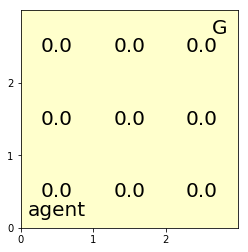

In [3]:
import matplotlib.pyplot as plt  
import matplotlib.patches as patches

def draw(mark_pos):
    fig, ax = plt.subplots()
    values = [[states[i][j].Q[states[i][j].best_action] for j in range(size)] for i in range(size)]
    mp = ax.pcolor(values, cmap=plt.cm.YlOrRd,vmin=0,vmax=8)
    ax.set_aspect(1)
    ax.set_xticks(range(size), minor=False)
    ax.set_yticks(range(size), minor=False)
    
    for x in range(len(values)):
        for y in range(len(values[0])):
            s = states[x][y]
            plt.text(x+0.5,y+0.5,int(1000*s.Q[s.best_action])/1000,ha = 'center', va = 'center', size=20)
            if states[x][y].goal:
                plt.text(x+0.75,y+0.75,"G",ha = 'center', va = 'center', size=20)
                
    plt.text(agent.pos[0]+0.5,agent.pos[1]+0.25,"agent",ha = 'center', va = 'center', size=20)
    
    if mark_pos == "all":   # 指定した位置にactionの文字列を書くという処理
        for x in range(size):
            for y in range(size):
                if states[x][y].goal: continue
                plt.text(x+0.5,y+0.25,states[x][y].best_action,ha = 'center', va = 'center', size=20)
    elif mark_pos != None: 
        s = states[mark_pos[0]][mark_pos[1]]
        plt.text(mark_pos[0]+0.5,mark_pos[1]+0.25,s.best_action,ha = 'center', va = 'center', size=20)
            
    plt.show()
    fig.clear()
    
draw(None)

### 状態遷移の実装

In [4]:
import random

def state_transition(s_pos,a):
    ###確率10%で元のまま ###
    if random.uniform(0,1) < 0.1:
        return s_pos
    
    x,y = s_pos
    if   a == "up": y += 1
    elif a == "down": y -= 1
    elif a == "right": x += 1
    elif a == "left": x -= 1
        
    if x < 0:       x = 0
    elif x >= size: x = size-1
    if y < 0:       y = 0
    elif y >= size: y = size-1
        
    return (x,y)

### 方策（$\epsilon$-greedy)

In [5]:
def e_greedy(s):
    if random.uniform(0,1) < 0.1: #10%でランダムに
        return random.choice(agent.actions)
    else:
        best_a = None
        best_q = 1000000000
        for a in s.Q:
            if best_q > s.Q[a]:
                best_q = s.Q[a]
                best_a = a
        s.best_action = best_a
        return best_a

### 1ステップの処理

s:(1, 1)　a:down s':(1, 1) a':down
----
s:(1, 1)　a:down s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':right
----
s:(1, 0)　a:right s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':right
----
s:(2, 0)　a:right s':(2, 0) a':right
----
s:(2, 0)　a:right s':(2, 0) a':up
----
s:(2, 0)　a:up s':(2, 1) a':down
----
s:(2, 1)　a:down s':(2, 0) a':left
----
s:(2, 0)　a:left s':(2, 0) a':left
----
s:(2, 0)　a:left s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':right
----
s:(1, 1)　a:right s':(2, 1) a':right
----
s:(2, 1)　a:right s':(2, 1) a':right
----
s:(2, 1)　a:right s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':down
----


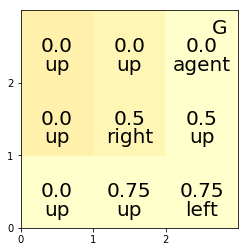

s:(1, 2)　a:down s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':right
----
s:(1, 2)　a:right s':(1, 2) a':up
----
s:(1, 2)　a:up s':(1, 2) a':up
----
s:(1, 2)　a:up s':(1, 2) a':left
----
s:(1, 2)　a:left s':(0, 2) a':down
----
s:(0, 2)　a:down s':(0, 2) a':down
----
s:(0, 2)　a:down s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':down
----
s:(1, 2)　a:down s':(1, 2) a':down
----
s:(1, 2)　a:down s':(1, 1) a':left
----
s:(1, 1)　a:left s':(0, 1) a':down
----
s:(0, 1)　a:down s':(0, 0) a':down
----
s:(0, 0)　a:down s':(0, 0) a':down
----
s:(0, 0)　a:down s':(0, 0) a':right
----
s:(0, 0)　a:right s':(1, 0) a':left
----
s:(1, 0)　a:left s':(0, 0) a':up
----
s:(0, 0)　a:up s':(0, 1) a':right
----
s:(0, 1)　a:right s':(1, 1) a':right
----
s:(1, 1)　a:right s':(2, 1) a':left
----
s:(2, 1)　a:left s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----


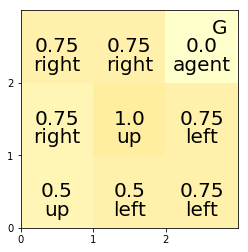

s:(1, 0)　a:right s':(2, 0) a':up
----
s:(2, 0)　a:up s':(2, 1) a':down
----
s:(2, 1)　a:down s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':right
----
s:(2, 0)　a:right s':(2, 0) a':right
----
s:(2, 0)　a:right s':(2, 0) a':left
----
s:(2, 0)　a:left s':(1, 0) a':left
----
s:(1, 0)　a:left s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':right
----
s:(0, 0)　a:right s':(0, 0) a':right
----
s:(0, 0)　a:right s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':left
----
s:(1, 1)　a:left s':(0, 1) a':up
----
s:(0, 1)　a:up s':(0, 2) a':up
----
s:(0, 2)　a:up s':(0, 2) a':up
----
s:(0, 2)　a:up s':(0, 2) a':left
----
s:(0, 2)　a:left s':(0, 2) a':left
----
s:(0, 2)　a:left s':(0, 2) a':left
----
s:(0, 2)　a:left s':(0, 2) a':down
----
s:(0, 2)　a:down s':(0, 1) a':left
--

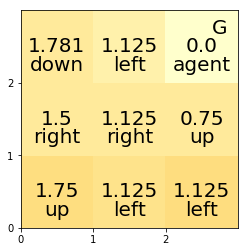

s:(2, 0)　a:up s':(2, 1) a':right
----
s:(2, 1)　a:right s':(2, 1) a':right
----
s:(2, 1)　a:right s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':down
----


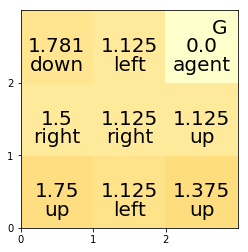

s:(0, 2)　a:up s':(0, 2) a':up
----
s:(0, 2)　a:up s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----


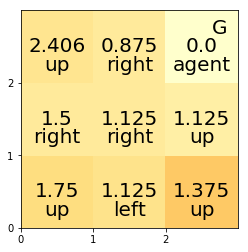

s:(1, 1)　a:left s':(0, 1) a':up
----
s:(0, 1)　a:up s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':up
----
s:(1, 2)　a:up s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----


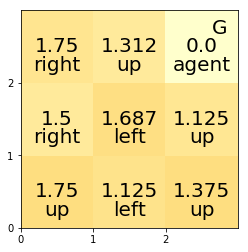

s:(0, 0)　a:down s':(0, 0) a':down
----
s:(0, 0)　a:down s':(0, 0) a':down
----
s:(0, 0)　a:down s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':right
----
s:(0, 0)　a:right s':(1, 0) a':right
----
s:(1, 0)　a:right s':(2, 0) a':left
----
s:(2, 0)　a:left s':(2, 0) a':left
----
s:(2, 0)　a:left s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----


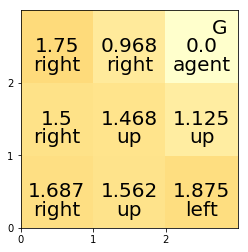

s:(2, 0)　a:up s':(2, 1) a':down
----
s:(2, 1)　a:down s':(2, 0) a':right
----
s:(2, 0)　a:right s':(2, 0) a':right
----
s:(2, 0)　a:right s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':up
----
s:(2, 0)　a:up s':(2, 1) a':left
----
s:(2, 1)　a:left s':(1, 1) a':right
----
s:(1, 1)　a:right s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':down
----


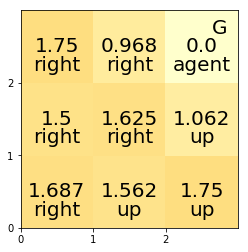

s:(0, 1)　a:right s':(1, 1) a':down
----
s:(1, 1)　a:down s':(1, 0) a':left
----
s:(1, 0)　a:left s':(0, 0) a':right
----
s:(0, 0)　a:right s':(0, 0) a':right
----
s:(0, 0)　a:right s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':right
----
s:(1, 0)　a:right s':(1, 0) a':right
----
s:(1, 0)　a:right s':(2, 0) a':up
----
s:(2, 0)　a:up s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':down
----


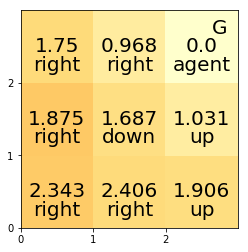

s:(1, 0)　a:up s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 0) a':left
----
s:(1, 0)　a:left s':(1, 0) a':left
----
s:(1, 0)　a:left s':(0, 0) a':up
----
s:(0, 0)　a:up s':(0, 0) a':up
----
s:(0, 0)　a:up s':(0, 1) a':down
----
s:(0, 1)　a:down s':(0, 0) a':down
----
s:(0, 0)　a:down s':(0, 0) a':down
----
s:(0, 0)　a:down s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':right
----
s:(0, 0)　a:right s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':right
----
s:(1, 0)　a:right s':(2, 0) a':left
----
s:(2, 0)　a:left s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----


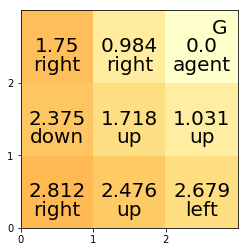

s:(0, 0)　a:up s':(0, 1) a':left
----
s:(0, 1)　a:left s':(0, 1) a':left
----
s:(0, 1)　a:left s':(0, 1) a':right
----
s:(0, 1)　a:right s':(1, 1) a':right
----
s:(1, 1)　a:right s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':down
----


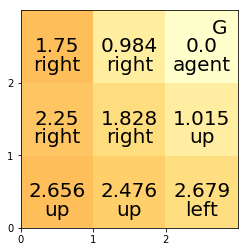

s:(1, 0)　a:up s':(1, 1) a':down
----
s:(1, 1)　a:down s':(1, 0) a':left
----
s:(1, 0)　a:left s':(0, 0) a':up
----
s:(0, 0)　a:up s':(0, 0) a':up
----
s:(0, 0)　a:up s':(0, 1) a':up
----
s:(0, 1)　a:up s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----


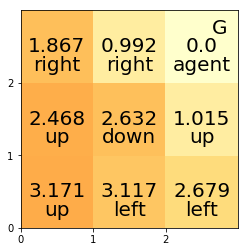

s:(0, 2)　a:down s':(0, 1) a':right
----
s:(0, 1)　a:right s':(1, 1) a':left
----
s:(1, 1)　a:left s':(1, 1) a':left
----
s:(1, 1)　a:left s':(0, 1) a':down
----
s:(0, 1)　a:down s':(0, 0) a':down
----
s:(0, 0)　a:down s':(0, 0) a':down
----
s:(0, 0)　a:down s':(0, 0) a':right
----
s:(0, 0)　a:right s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----


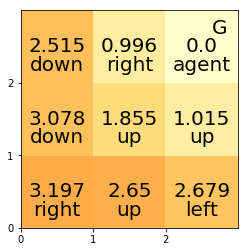

s:(1, 0)　a:right s':(2, 0) a':up
----
s:(2, 0)　a:up s':(2, 0) a':up
----
s:(2, 0)　a:up s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':right
----


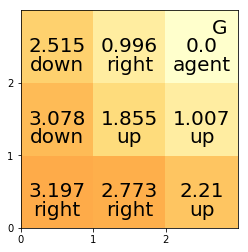

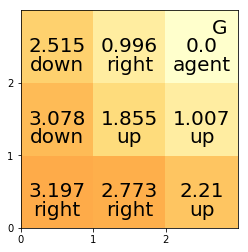

s:(2, 0)　a:up s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':down
----


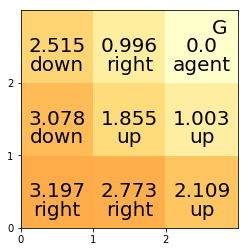

s:(0, 1)　a:right s':(1, 1) a':right
----
s:(1, 1)　a:right s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':down
----


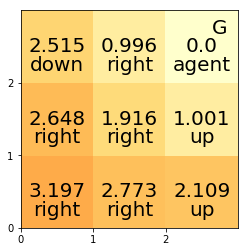

s:(0, 1)　a:up s':(0, 2) a':left
----
s:(0, 2)　a:left s':(0, 2) a':left
----
s:(0, 2)　a:left s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----


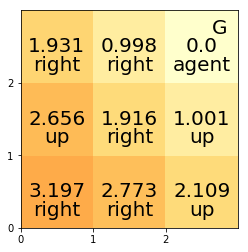

s:(1, 0)　a:up s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----


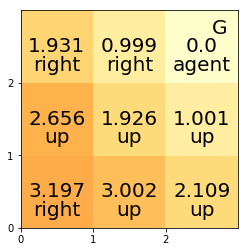

s:(0, 1)　a:left s':(0, 1) a':left
----
s:(0, 1)　a:left s':(0, 1) a':right
----
s:(0, 1)　a:right s':(1, 1) a':right
----
s:(1, 1)　a:right s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':down
----


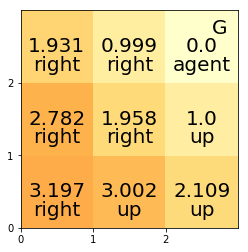

s:(1, 1)　a:up s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----


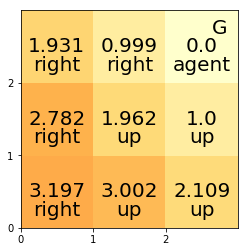

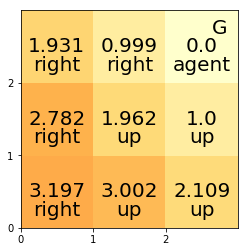

s:(0, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----


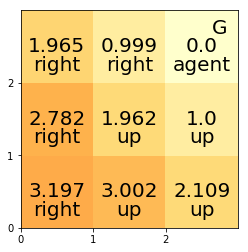

s:(1, 2)　a:right s':(2, 2) a':down
----


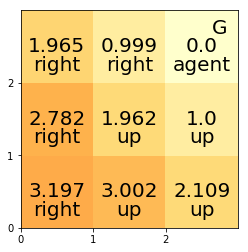

s:(0, 1)　a:up s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----


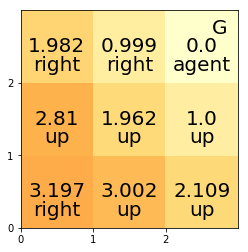

s:(2, 1)　a:up s':(2, 2) a':down
----


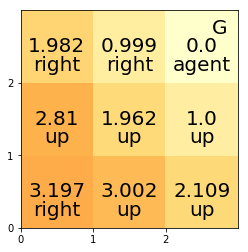

s:(0, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----


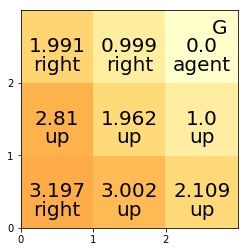

s:(1, 1)　a:right s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':down
----


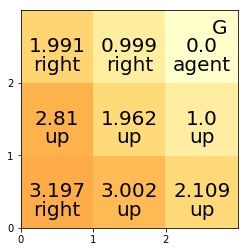

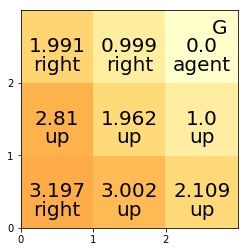

s:(1, 1)　a:up s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----


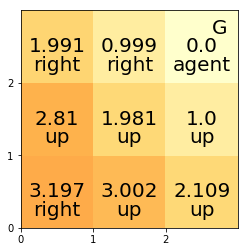

s:(2, 1)　a:up s':(2, 2) a':down
----


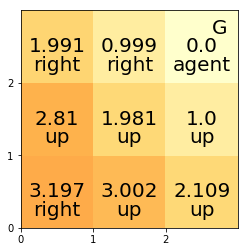

s:(0, 1)　a:right s':(1, 1) a':right
----
s:(1, 1)　a:right s':(1, 1) a':right
----
s:(1, 1)　a:right s':(2, 1) a':left
----
s:(2, 1)　a:left s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':right
----
s:(1, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':right
----


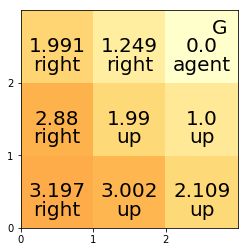

s:(1, 2)　a:down s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':left
----
s:(1, 2)　a:left s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----


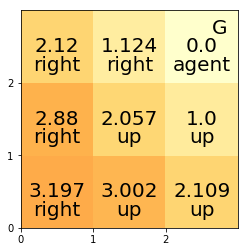

s:(0, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----


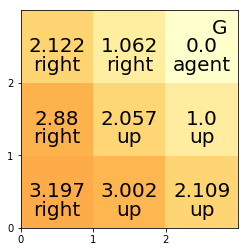

s:(2, 0)　a:up s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':down
----


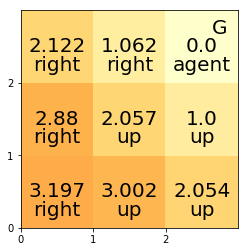

s:(0, 1)　a:up s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----


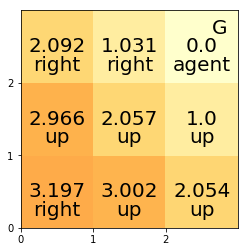

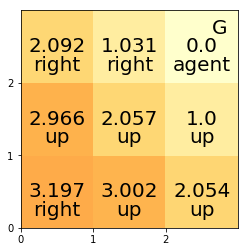

s:(0, 2)　a:right s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----


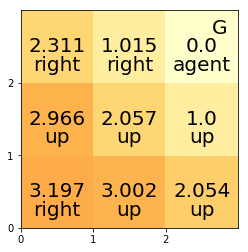

s:(0, 1)　a:left s':(0, 1) a':right
----
s:(0, 1)　a:right s':(1, 1) a':down
----
s:(1, 1)　a:down s':(1, 0) a':right
----
s:(1, 0)　a:right s':(2, 0) a':up
----
s:(2, 0)　a:up s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':down
----


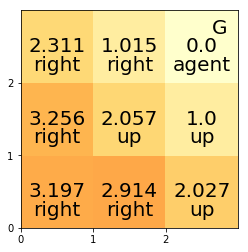

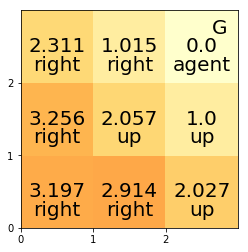

s:(2, 1)　a:up s':(2, 2) a':down
----


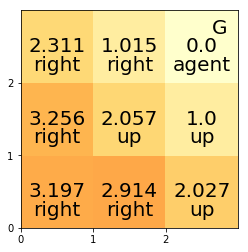

s:(0, 1)　a:up s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----


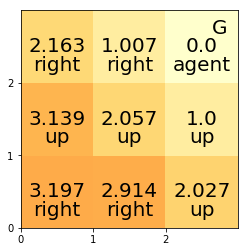

s:(0, 1)　a:down s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':up
----
s:(0, 0)　a:up s':(0, 1) a':up
----
s:(0, 1)　a:up s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----


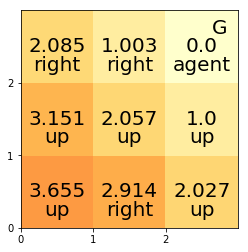

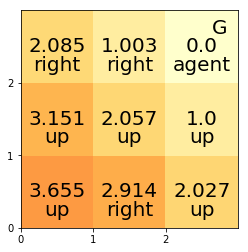

s:(2, 0)　a:up s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':down
----


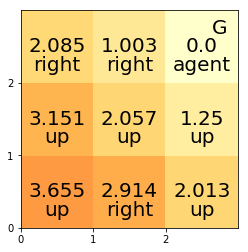

s:(0, 0)　a:right s':(1, 0) a':right
----
s:(1, 0)　a:right s':(2, 0) a':up
----
s:(2, 0)　a:up s':(2, 0) a':up
----
s:(2, 0)　a:up s':(2, 0) a':right
----
s:(2, 0)　a:right s':(2, 0) a':right
----
s:(2, 0)　a:right s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':right
----
s:(2, 0)　a:right s':(2, 0) a':left
----
s:(2, 0)　a:left s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':right
----
s:(1, 0)　a:right s':(2, 0) a':up
----
s:(2, 0)　a:up s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':down
----


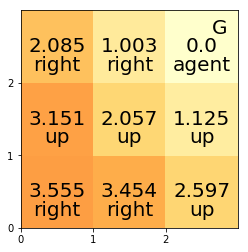

s:(2, 1)　a:up s':(2, 2) a':down
----


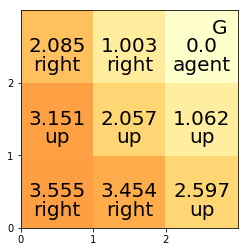

s:(0, 0)　a:down s':(0, 0) a':down
----
s:(0, 0)　a:down s':(0, 0) a':right
----
s:(0, 0)　a:right s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----


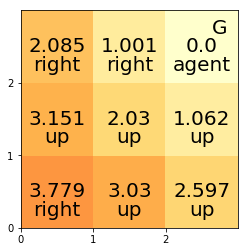

s:(1, 2)　a:right s':(2, 2) a':down
----


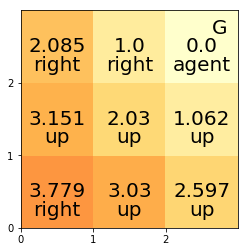

s:(1, 1)　a:up s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----


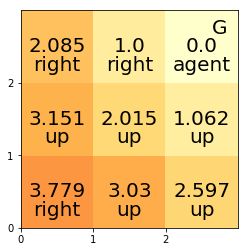

s:(2, 0)　a:up s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':down
----


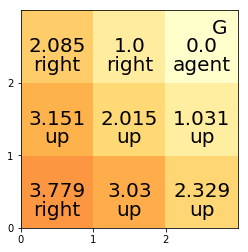

s:(2, 0)　a:up s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':down
----


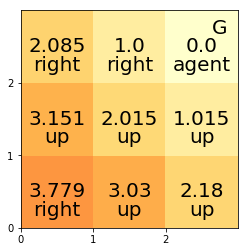

s:(0, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':up
----


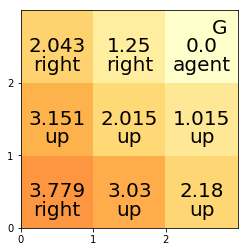

s:(0, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----


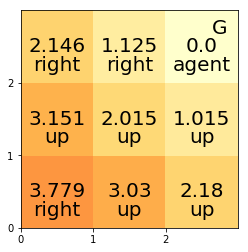

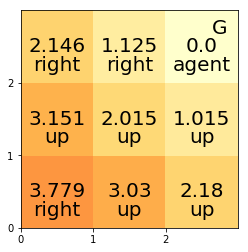

s:(0, 0)　a:up s':(0, 1) a':up
----
s:(0, 1)　a:up s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':up
----


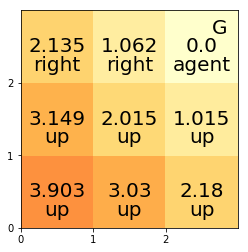

s:(2, 1)　a:up s':(2, 2) a':down
----


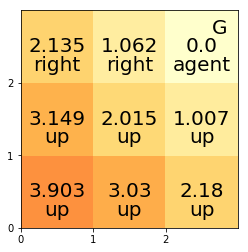

s:(0, 0)　a:right s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':left
----
s:(1, 1)　a:left s':(0, 1) a':up
----
s:(0, 1)　a:up s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----


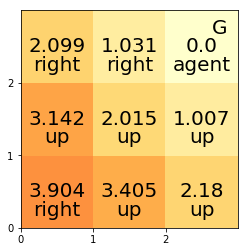

s:(0, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----


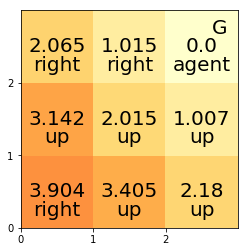

s:(1, 0)　a:left s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':up
----
s:(0, 0)　a:up s':(0, 1) a':up
----
s:(0, 1)　a:up s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----


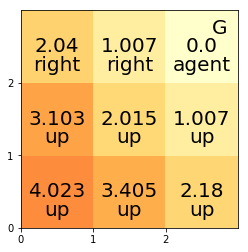

s:(1, 0)　a:up s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----


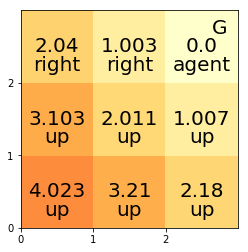

s:(1, 0)　a:up s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----


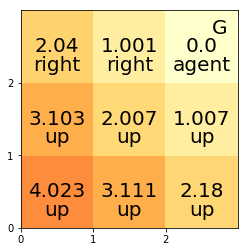

s:(0, 2)　a:right s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----


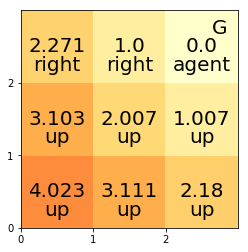

s:(0, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----


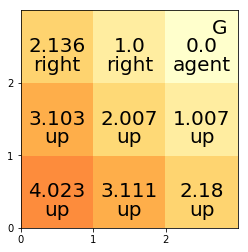

s:(1, 2)　a:right s':(2, 2) a':down
----


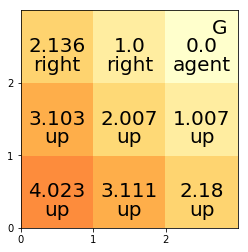

s:(0, 2)　a:right s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----


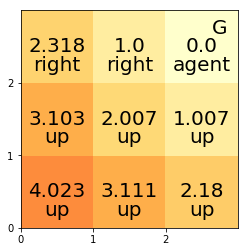

s:(2, 1)　a:up s':(2, 2) a':down
----


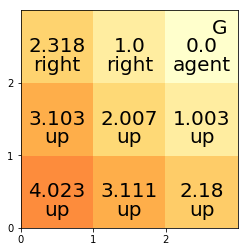

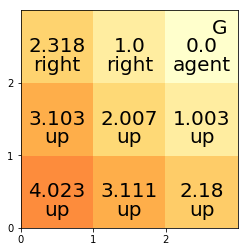

s:(0, 0)　a:right s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':up
----
s:(1, 2)　a:up s':(1, 2) a':left
----
s:(1, 2)　a:left s':(0, 2) a':right
----
s:(0, 2)　a:right s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----


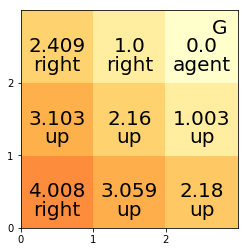

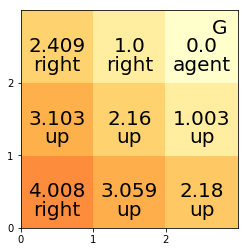

s:(0, 0)　a:right s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----


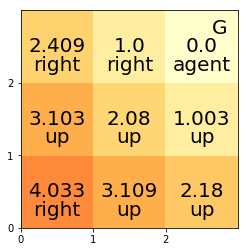

s:(2, 1)　a:up s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':down
----


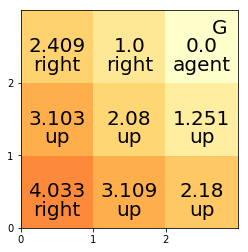

s:(1, 2)　a:right s':(2, 2) a':down
----


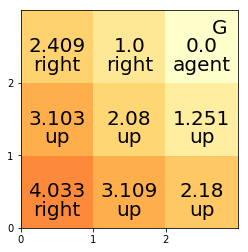

s:(2, 1)　a:up s':(2, 2) a':down
----


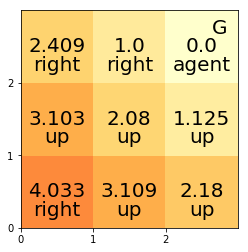

s:(1, 2)　a:right s':(2, 2) a':down
----


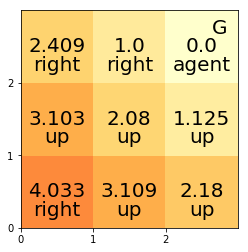

s:(0, 1)　a:up s':(0, 2) a':up
----
s:(0, 2)　a:up s':(0, 2) a':up
----
s:(0, 2)　a:up s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----


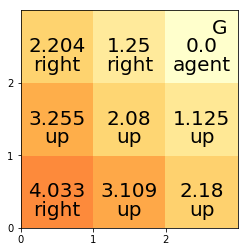

s:(2, 1)　a:up s':(2, 2) a':down
----


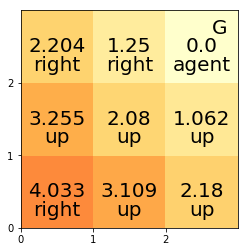

s:(0, 0)　a:up s':(0, 1) a':down
----
s:(0, 1)　a:down s':(0, 0) a':right
----
s:(0, 0)　a:right s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----


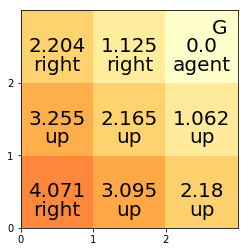

s:(1, 0)　a:up s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----


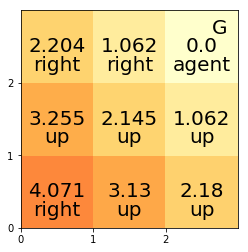

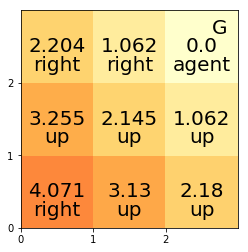

s:(1, 1)　a:up s':(1, 2) a':right
----
s:(1, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----


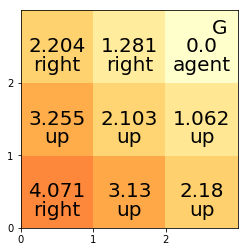

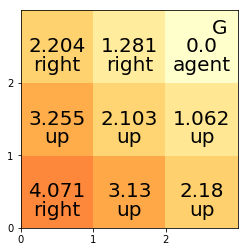

s:(0, 1)　a:up s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----


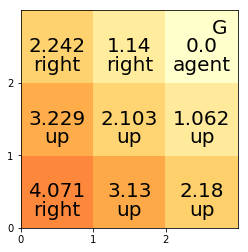

s:(0, 0)　a:right s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':up
----


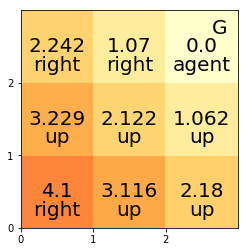

s:(0, 0)　a:left s':(0, 0) a':right
----
s:(0, 0)　a:right s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':up
----


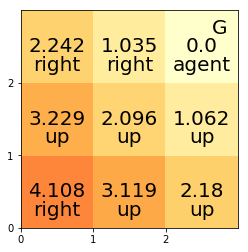

s:(2, 0)　a:up s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':down
----


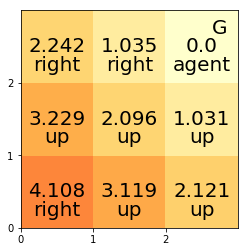

s:(0, 1)　a:up s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----


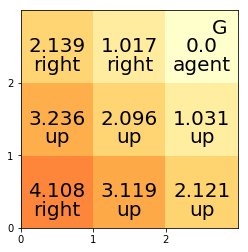

s:(2, 0)　a:up s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':down
----


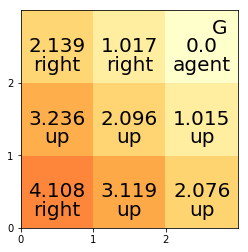

s:(1, 1)　a:up s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----


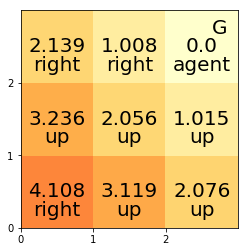

s:(1, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':left
----


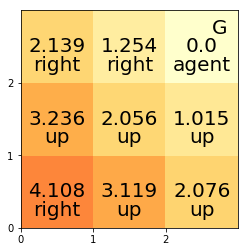

s:(2, 0)　a:up s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':down
----


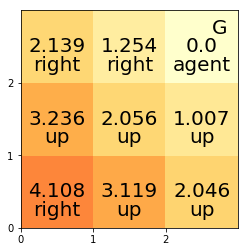

s:(2, 0)　a:up s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':down
----


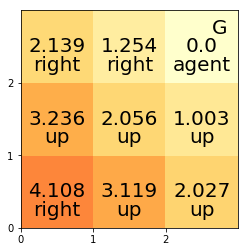

s:(0, 1)　a:left s':(0, 1) a':up
----
s:(0, 1)　a:up s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----


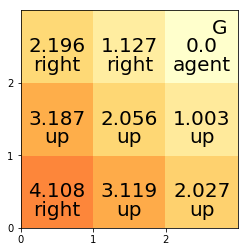

s:(0, 1)　a:left s':(0, 1) a':up
----
s:(0, 1)　a:up s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----


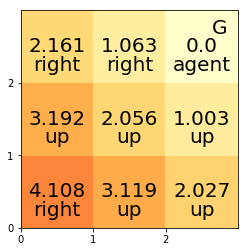

s:(0, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----


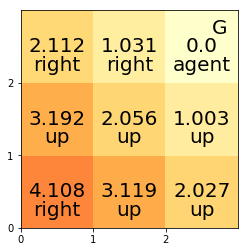

s:(0, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----


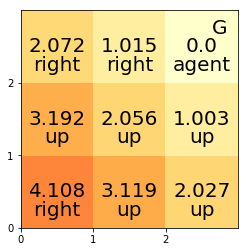

s:(1, 0)　a:up s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----


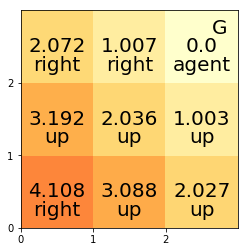

s:(0, 1)　a:up s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----


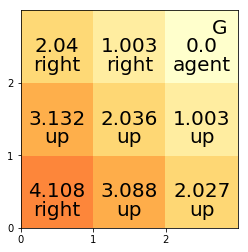

s:(1, 0)　a:up s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----


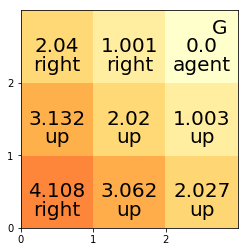

s:(1, 0)　a:up s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----


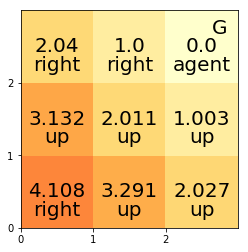

In [6]:
alpha = 0.5
gamma = 1.0

def sarsa(s_pos,a):
    s = states[s_pos[0]][s_pos[1]]
    s_next_pos = state_transition(s_pos,a)
    s_next = states[s_next_pos[0]][s_next_pos[1]]
    a_next = e_greedy(s_next)
    
    q = (1.0-alpha)*s.Q[a] + alpha * (1.0 + gamma * s_next.Q[a_next])
    print("s:" + str(s_pos)+ "　a:" + a + " s':" + str(s_next_pos) + " a':" + a_next)
    print("----")
    return s_next_pos, a_next, q

def one_trial():
    agent.pos = (random.randrange(size),random.randrange(size))
    a = e_greedy(states[agent.pos[0]][agent.pos[1]])
    if states[agent.pos[0]][agent.pos[1]].goal:
        return
          
    while True:
        #draw(None)
        s_next, a_next, q = sarsa(agent.pos,a)
        states[agent.pos[0]][agent.pos[1]].Q[a] = q
        agent.pos = s_next
        a = a_next
        if states[agent.pos[0]][agent.pos[1]].goal:
            break
            
            
for i in range(100):
    one_trial()
    draw("all")